In [5]:
import os
import pandas as pd

print(os.getcwd())

mydata = pd.read_csv("sentiment_Subset.csv", header = 0)
print(mydata.shape)

# Use 10000 for testing
mydata = mydata[:10000] 
mydata.head()



C:\Users\rishi
(160000, 2)


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [6]:
import re

def clean_text(string_in):
    string_in = re.sub(r"@\w+", "", string_in) # Remove twitter handle
    string_in = re.sub(r"\d", "", string_in)   # Remove numbers  
    string_in = re.sub(r"_+", "", string_in)   # Remove consecutive underscores
    string_in = string_in.lower()              # Tranform to lower case    
    
    return string_in.strip()

mydata["tweet_text_cleaned"] = mydata.tweet_text.apply(clean_text)
mydata.head()

,sentiment_label,tweet_text,tweet_text_cleaned
0,4,"@elephantbird Hey dear, Happy Friday to You A...","hey dear, happy friday to you already had you..."
1,4,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's...","i reckon he'll play, even if he's not %...but ..."
3,0,@vaLewee I know! Saw it on the news!,i know! saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...,very sad that http://www.fabchannel.com/ has c...


In [7]:
from nltk.tokenize import RegexpTokenizer
preprocessed = [" ".join(RegexpTokenizer(r'\w+').\
                         tokenize(mydata.tweet_text_cleaned[idx])) \
                for idx in mydata.index]

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

custom_stop_words = ["on","the"]
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))
print(tfidf[0:1])

Created document-term matrix of size 10000 x 13379
  (0, 6898)	0.33793047336148796
  (0, 1371)	0.48029634268118193
  (0, 9666)	0.44747321689772623
  (0, 4347)	0.3551708501054696
  (0, 5045)	0.28572571469808344
  (0, 2832)	0.3904222672812511
  (0, 5196)	0.30768665058230316


In [16]:
from sklearn import decomposition
import numpy as np
nmf = decomposition.NMF(init = 'nndsvd', n_components = 3, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated factor W of size %s and factor H of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()
n_top_words = 10

# Print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated factor W of size (10000, 3) and factor H of size (3, 13379)
Topic #0:
good day work just today morning going like night really

Topic #1:
quot love http just com know amp new like best

Topic #2:
thanks following ff lol got haha great hey hope follow



In [17]:
!pip install wordcloud

In [20]:
mydf = pd.DataFrame({"feature_name": feature_names})

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

mywords_topic1 = []
mywords_topic2 = []
mywords_topic3 = []

for order_id, key, num1, num2, num3 in mylist:
    mywords_topic1.append((key, num1))
    mywords_topic2.append((key, num2))
    mywords_topic3.append((key, num3))

mywords_topic1 = sorted(mywords_topic1, key=lambda myword: myword[1], reverse=True)
print(mywords_topic1[1])
mywords_topic2 = sorted(mywords_topic2, key=lambda myword: myword[1], reverse=True)
print(mywords_topic2[1])
mywords_topic3 = sorted(mywords_topic3, key=lambda myword: myword[1], reverse=True)
print(mywords_topic3[1])

('day', 0.9754276746763838)
('love', 0.1734448077870142)
('following', 0.1616644923141531)


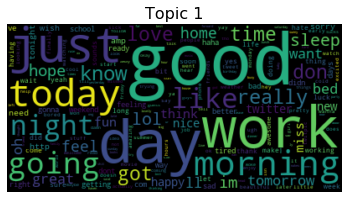

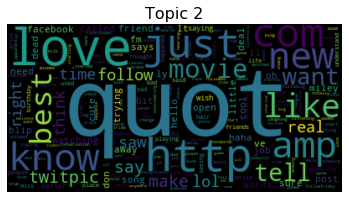

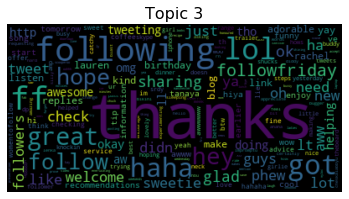

In [21]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline

def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    
    plt.title('Topic %s' %str(topic_number), size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

draw_wordcloud(dict(mywords_topic1), topic_number=1)
draw_wordcloud(dict(mywords_topic2), topic_number=2)
draw_wordcloud(dict(mywords_topic3), topic_number=3)

In [36]:
# Prediction example
text_new = preprocessed[0:5]
tfidf_new = vectorizer.transform(text_new)
W_new = nmf.transform(tfidf_new)
print(text_new)
W_new

['hey dear happy friday to you already had your rice s bowl for lunch', 'ughhh layin downnnn waiting for zeina to cook breakfast', 'i reckon he ll play even if he s not but i know nothing it won t be the same without him', 'i know saw it on the news', 'very sad that http www fabchannel com has closed down one of the few web services that i ve used for over years']


array([[0.01436209, 0.00102615, 0.00396428],
       [0.00263124, 0.00048925, 0.        ],
       [0.02592896, 0.00430011, 0.0001213 ],
       [0.02484048, 0.00870934, 0.00070201],
       [0.01683019, 0.01023388, 0.00027904]])